In [1]:
#importing libraries
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.optimizers import RMSprop

import pprint
import tensorflow as tf
import zipfile
from PIL import Image
import random
import os
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import cv2 as cv
from numpy import interp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import shutil

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Preparing Images

In [2]:
'''
the 20x magnification are stored under the folder tiled_image/20
the 40x magnification are stored under the folder tiled_image/40

'''

#loading file from Drive

mag= '40'

if mag == '20':

  local_zip = '/content/drive/My Drive/TCGA data/tiled_image/'+mag+'/exon_19.zip'

  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp/train_dir')
  zip_ref.close()

  local_zip = '/content/drive/My Drive/TCGA data/tiled_image/'+mag+'/exon_21.zip'

  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp/train_dir')
  zip_ref.close() 

elif mag == '40':

  #exon 21 files in 40x magnification is separated into two zip files due to size

  local_zip = '/content/drive/My Drive/TCGA data/tiled_image/'+mag+'/exon_19.zip'

  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp/train_dir')
  zip_ref.close()

  local_zip = '/content/drive/My Drive/TCGA data/tiled_image/'+mag+'/exon_21_1.zip'

  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp/train_dir')
  zip_ref.close() 

  local_zip = '/content/drive/My Drive/TCGA data/tiled_image/'+mag+'/exon_21_2.zip'

  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp/train_dir')
  zip_ref.close()

In [3]:
#move files to another folder to get rid of additional files automatically
#added by Colab when extracting the zip file

os.mkdir('/tmp/train')
os.mkdir('/tmp/train/exon_19')
os.mkdir('/tmp/train/exon_21')

In [4]:
path= '/tmp/train_dir/'
img_folder_path = "/tmp/train/"

if mag == '20':

  exons = ['exon_19', 'exon_21']

  for ex in exons:
    dirListing = sorted(os.listdir(path+ ex))
    for i in dirListing[:]:
      if i!= '.DS_Store':
        dest = shutil.move(path+ex+'/'+i, "/tmp/train/"+ex)

elif mag == '40':

  exons= ['exon_19']

  for ex in exons:
    dirListing = sorted(os.listdir(path+ ex))
    for i in dirListing[:]:
      if i!= '.DS_Store':
        dest = shutil.move(path+ex+'/'+i, "/tmp/train/"+ex)

  exons= ['exon_21_1', 'exon_21_2']

  for ex in exons:
    dirListing = sorted(os.listdir(path+ ex))
    for i in dirListing[:]:
      if i!= '.DS_Store':
        dest = shutil.move(path+ex+'/'+i, "/tmp/train/exon_21")

In [5]:
#check that we have the correct number of patient files

assert len(os.listdir( "/tmp/train/exon_21" )) == 17 and len(os.listdir( "/tmp/train/exon_19" )) == 18

In [6]:
#get the number of tile imaged for each patient

path= '/tmp/train/'

dirListing = sorted(os.listdir(path+'exon_19'))
num_images_19= [0]*len(dirListing)

for k, iter in zip(dirListing[:], range(len(dirListing))):
  
  if k!= '.DS_Store':
    dirListin = os.listdir(path+'exon_19'+'/'+k)
    for l in dirListin:
      if l!= '.DS_Store':
        dirList = os.listdir(path+'exon_19'+'/'+k+'/'+l)
        for m in dirList:
          if m!= '.DS_Store':
              num_images_19[iter]+=1

In [7]:
sum(num_images_19)

71703

In [8]:
path= '/tmp/train/'
dirListing = sorted(os.listdir(path+'exon_21'))
num_images_21= [0]*len(dirListing)

for k, iter in zip(dirListing[:], range(len(dirListing))):
  
  if k!= '.DS_Store':
    dirListin = os.listdir(path+'exon_21'+'/'+k)
    for l in dirListin:
      if l!= '.DS_Store':
        dirList = os.listdir(path+'exon_21'+'/'+k+'/'+l)
        for m in dirList:
          if m!= '.DS_Store':
              num_images_21[iter]+=1

In [9]:
sum(num_images_21)

105685

In [10]:
#generate random numbers to assign folders into the validation set.

rand = random.sample(range(0, 17), 6)

os.mkdir('/tmp/val')
os.mkdir('/tmp/val/exon_19')
os.mkdir('/tmp/val/exon_21')

In [12]:
#get the ranking in terms of number of tiled images for each 
#patient

rank_21= []
for i in sorted(num_images_21[:]):
  rank_21.append(num_images_21.index(i))

rank_19= []
for i in sorted(num_images_19[:]):
  rank_19.append(num_images_19.index(i))


In [37]:
img_folder_path = "/tmp/train/"

exon= 'exon_19'

dirListing = sorted(os.listdir(img_folder_path+ exon))
for i in rand:
   index= rank_19[i]
   dest = shutil.move(img_folder_path+exon+'/'+dirListing[index], "/tmp/val/"+exon)
                      
exon= 'exon_21'

dirListing = sorted(os.listdir(img_folder_path+ exon))
for i in rand:
   index= rank_21[i]
   dest = shutil.move(img_folder_path+exon+'/'+dirListing[index], "/tmp/val/"+exon)


In [38]:
train_data_dir = '/tmp/train'

#preprocessing_function for color augentation. not used for this project due to 
#computational resources.

'''
def augmentation_stain(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  sig= random.uniform(0.2, 0.5)                     
  augmentor = staintools.StainAugmentor(method='vahadane', sigma1=sig, sigma2=sig)
  img= img.astype(np.uint8)
  augmentor.fit(img)
  augmented_image = augmentor.pop()

  return augmented_image/255.
'''

train_datagen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_directory(directory=train_data_dir,
                                  target_size=(299,299),
                                  batch_size=64,
                                  follow_links= True)

Found 104169 images belonging to 2 classes.


In [39]:
val_data_dir = '/tmp/val'

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_generator = val_datagen.flow_from_directory(directory= val_data_dir,
                                target_size=(299,299),
                                batch_size=64)

Found 73219 images belonging to 2 classes.


# Building Model

In [16]:
def make_model(output):
  base_model = InceptionV3(weights='imagenet',include_top=False)
  x = base_model.output
  x1 = GlobalAveragePooling2D()(x)
  x2 = Dense(1024,activation='relu')(x1)
  x3 = Dense(512,activation='relu')(x2)
  x4 = Dense(128,activation='relu')(x3)
  predictions = Dense(output,activation='softmax')(x4)
  model = Model(inputs=base_model.input,outputs=predictions)
  return model

In [17]:
# i chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest. according to 
# https://keras.io/applications/#inceptionv3 

def setup_to_fine_tune(model):
  for layer in model.layers[:249]:
    layer.trainable = False
  for layer in model.layers[249:]:
    layer.trainable = True
  model.compile(optimizer=RMSprop(lr=0.01, momentum= 0.01, epsilon=0.1, decay= 0.2),loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
checkpoint_dir = '/content/drive/My Drive/TCGA data/weights/40x_1921_2/'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def make_or_restore_model(output):
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + '/' + name
                   for name in os.listdir(checkpoint_dir)]

    if checkpoints:
      latest_checkpoint = max(checkpoints, key=os.path.getctime)
      print('Restoring from', latest_checkpoint)
      return tf.keras.models.load_model(latest_checkpoint)
    else:
      print('Creating a new model')
      return make_model(output)

In [49]:
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the acc in the folder name.
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + '/accuracy={accuracy:.3f}',
        monitor='loss',
        mode='min',
        save_freq=112)
]

In [50]:
model = make_or_restore_model(2)
setup_to_fine_tune(model)

Creating a new model


In [51]:
history_tl = model.fit(train_generator,
                    steps_per_epoch=112,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=5,
                    callbacks= callbacks)


Epoch 1/10
112/112 [==============================] - 204s 2s/step - loss: 0.6463 - accuracy: 0.6142 - val_loss: 0.7043 - val_accuracy: 0.5562
Epoch 2/10
112/112 [==============================] - 196s 2s/step - loss: 0.6019 - accuracy: 0.6786 - val_loss: 0.7136 - val_accuracy: 0.5750
Epoch 3/10
112/112 [==============================] - 194s 2s/step - loss: 0.5926 - accuracy: 0.6974 - val_loss: 0.7118 - val_accuracy: 0.6000
Epoch 4/10
112/112 [==============================] - 194s 2s/step - loss: 0.5805 - accuracy: 0.7069 - val_loss: 0.7373 - val_accuracy: 0.6000
Epoch 5/10
112/112 [==============================] - 203s 2s/step - loss: 0.5743 - accuracy: 0.7148 - val_loss: 0.7061 - val_accuracy: 0.6156
Epoch 6/10
112/112 [==============================] - 199s 2s/step - loss: 0.5747 - accuracy: 0.7119 - val_loss: 0.6905 - val_accuracy: 0.6656
Epoch 7/10
112/112 [==============================] - 199s 2s/step - loss: 0.5723 - accuracy: 0.7062 - val_loss: 0.7157 - val_accuracy: 0.5844

In [52]:
best = make_or_restore_model(2)

Restoring from /content/drive/My Drive/TCGA data/weights/40x_1921_3//accuracy=0.726


# Generate ROC Plot

In [53]:
y_pred = best.predict(val_generator)
labels= val_generator.classes

In [54]:
y_test= []
for i in range(len(labels)):
  if labels[i]==0:
    y_test.append([1, 0])
  else:
    y_test.append([0, 1])

In [55]:
y_pred_keras = y_pred.ravel()
y_true= np.array(y_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

In [56]:
n_bootstraps = 1000
seed = 42  
bootstrapped_scores = []

r = np.random.RandomState(seed)
for i in range(n_bootstraps):

    # bootstrap by sampling with replacement 
    indices = r.randint(0, len(y_pred_keras), len(y_pred_keras))
    if len(np.unique(y_true[indices])) < 2:
       
        continue

    score = roc_auc_score(y_true[indices], y_pred_keras[indices])
    bootstrapped_scores.append(score)
    

In [57]:
# Compute the lower and upper bound of the 95% confidence interval

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

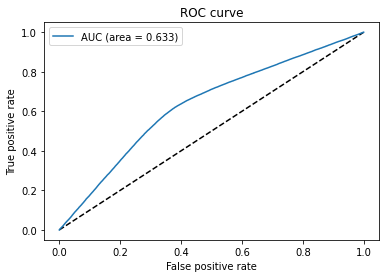

 
             95% CI: [0.630, 0.636]


In [58]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(" ")
print("             95% CI: [{:0.3f}, {:0.3}]".format(
    confidence_lower, confidence_upper))

In [59]:
# per slide ROC

y_true = []
for _ in range(6):
  y_true.append([1, 0])

for _ in range(6):
  y_true.append([0, 1])

num_list = []

for i in rand:
   index= rank_19[i]
   num_list.append(num_images_19[index])

for i in rand:
   index= rank_21[i]
   num_list.append(num_images_21[index])   

In [60]:
#averaging out the probability from each individual tile

y_pred_slide = np.array([[0.0, 0.0]]* 12)

start = 0
end = 0

for i in range(len(num_list)):
  end += num_list[i]

  for j in range(start, end):
    y_pred_slide[i] += y_pred[j]

  start = end

for i in range(len(num_list)):
  y_pred_slide[i] = y_pred_slide[i]/ num_list[i]

In [61]:
y_pred_keras = y_pred_slide.ravel()
y_true= np.array(y_true).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

In [62]:
n_bootstraps = 1000
seed = 42  
bootstrapped_scores = []

r = np.random.RandomState(seed)
for i in range(n_bootstraps):

    # bootstrap by sampling with replacement on the prediction indices
    indices = r.randint(0, len(y_pred_keras), len(y_pred_keras))
    if len(np.unique(y_true[indices])) < 2:
       
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred_keras[indices])
    bootstrapped_scores.append(score)

In [63]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval

confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

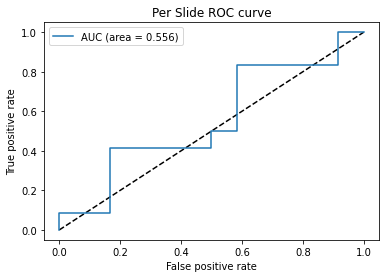

 
             95% CI: [0.333, 0.793]


In [64]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Per Slide ROC curve')
plt.legend(loc='best')
plt.show()

print(" ")
print("             95% CI: [{:0.3f}, {:0.3}]".format(
    confidence_lower, confidence_upper))

In [66]:
#move validation set back to the train set to perform another trial

path = "/tmp/val/"
exons= ['exon_21', 'exon_19']

for ex in exons:
  dirListing = sorted(os.listdir(path+ ex))
  for i in dirListing[:]:
    if i!= '.DS_Store':
      dest = shutil.move(path+ex+'/'+i, "/tmp/train/"+ex)